<a href="https://colab.research.google.com/github/hwanython/kaggle-chestXray-penumonia/blob/main/04_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import tensorflow.keras
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
data_dir = '/content/drive/MyDrive/AI/01.Kaggle/Chest_X_ray_image/data/chest_xray'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')

In [ ]:
batch_size = 16
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=10, zoom_range=0.2, horizontal_flip=True, width_shift_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir, shuffle=True,
    target_size=(IMG_HEIGHT,IMG_WIDTH),
    batch_size = batch_size,
    class_mode ='binary'
)
val_generator = train_datagen.flow_from_directory(
    val_dir, shuffle=True,
    target_size=(IMG_HEIGHT,IMG_WIDTH),
    batch_size = batch_size,
    class_mode ='binary'
)

Found 3652 images belonging to 2 classes.
Found 1580 images belonging to 2 classes.


In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout, BatchNormalization, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2

In [7]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [10]:
conv_base = VGG16(include_top = False,weights='imagenet')
for i in conv_base.layers:
  i.trainable =False
X = conv_base.output
X = tensorflow.keras.layers.GlobalAveragePooling2D()(X)
X = tensorflow.keras.layers.Dense(128, activation='relu')(X)
prediction_layer = tensorflow.keras.layers.Dense(1, activation='sigmoid')(X)

model = tensorflow.keras.Model(conv_base.input, prediction_layer)

model.summary()




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

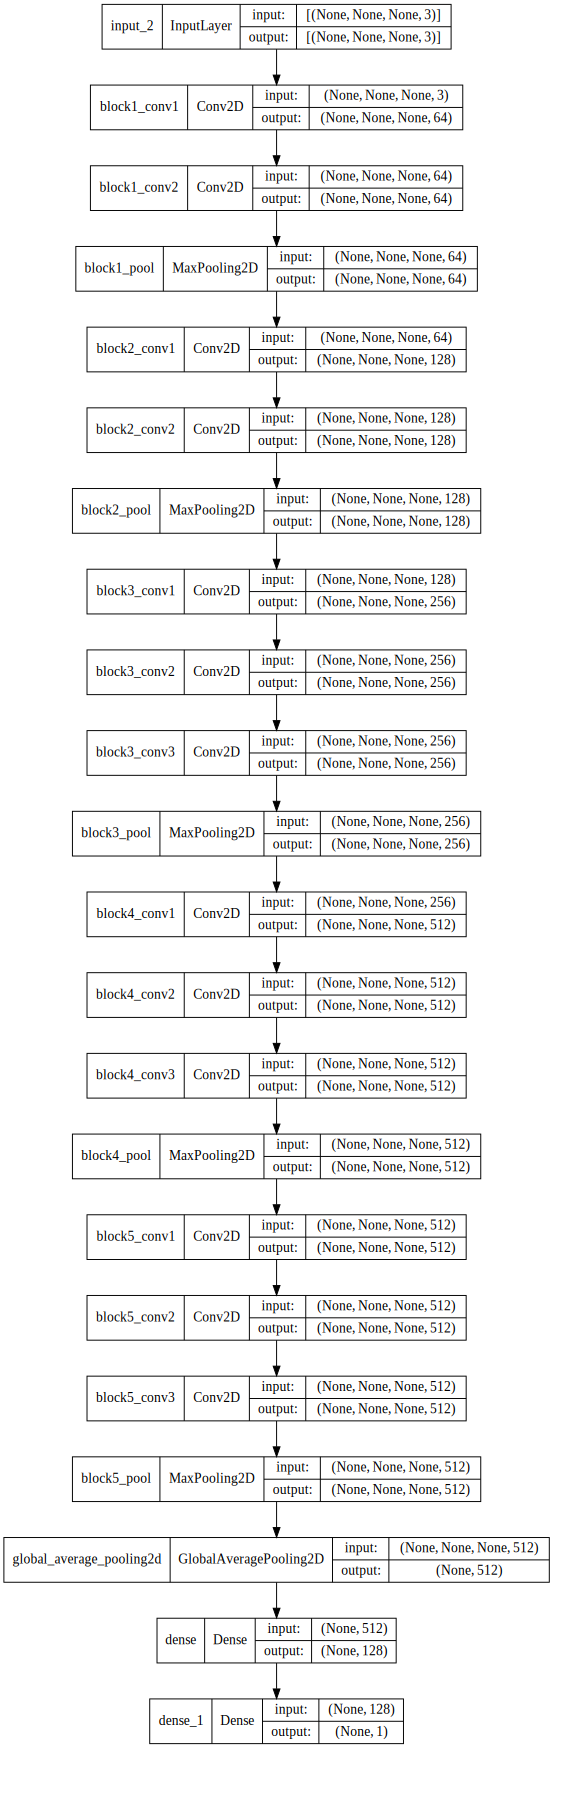

In [21]:
# %matplotlib inline
SVG(model_to_dot(model, show_shapes=True,dpi=70).create(prog='dot', format='svg'))

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

# 콜백 사용

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import os
import tensorflow as tf

def checkpoint(ckpt_dir, monitor):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir, exist_ok=True)
    path = os.path.join(ckpt_dir, "ep{epoch:02d}-loss{loss:.4f}-acc{acc:.4f}-val_loss{val_loss:.4f}-val_acc{val_acc:.4f}.h5")
    ckpt = ModelCheckpoint(
        filepath=path, monitor=monitor, verbose=1, save_best_only=True,
        save_weights_only=False, mode='auto', save_freq='epoch',
        options=None)
    return ckpt

def ES(patience):
    callback = EarlyStopping(monitor='val_loss', patience=patience)
    return callback
    
def reducelr():
    lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=12,
        min_lr=1e-8
    )
    return lr

In [ ]:
ckpt_dir = '/content/drive/MyDrive/AI/01.Kaggle/Chest_X_ray_image/data/chest_xray/ckpt_model'

In [ ]:
history = model.fit(
    train_generator, 
    steps_per_epoch = 100,
    epochs = 20,
    validation_data = val_generator,
    verbose=1, callbacks=[checkpoint(ckpt_dir,'val_acc'), ES(10), reducelr()])

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.4387 - acc: 0.7950
Epoch 00001: val_acc improved from -inf to 0.85443, saving model to /content/drive/MyDrive/AI/01.Kaggle/Chest_X_ray_image/data/chest_xray/ckpt_model/ep01-loss0.4387-acc0.7950-val_loss0.3251-val_acc0.8544.h5
100/100 [==============================] - 481s 5s/step - loss: 0.4387 - acc: 0.7950 - val_loss: 0.3251 - val_acc: 0.8544 - lr: 0.0010
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.2781 - acc: 0.8917
Epoch 00002: val_acc improved from 0.85443 to 0.88544, saving model to /content/drive/MyDrive/AI/01.Kaggle/Chest_X_ray_image/data/chest_xray/ckpt_model/ep02-loss0.2781-acc0.8917-val_loss0.2593-val_acc0.8854.h5
100/100 [==============================] - 127s 1s/step - loss: 0.2781 - acc: 0.8917 - val_loss: 0.2593 - val_acc: 0.8854 - lr: 0.0010
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.2321 - acc: 0.9062
Epoch 00003: val_acc improved from 0.885

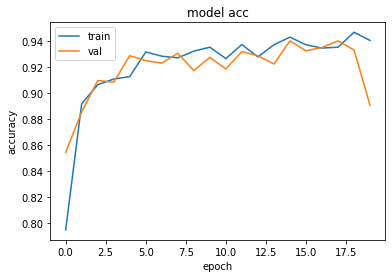

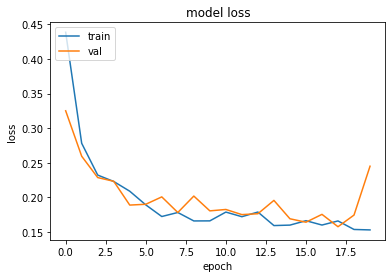

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()